# Applied Data Science Capstone Project
## Selecting a Location Near a University to Open a Student Coffee Shop

#### By: Hiba Jadallah

### Table of Contents
* [Introduction](#introduction) 
* [Business Problem](#businessproblem) 
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion and Future Directions](#conclusion)

### Introduction <a name="introduction"></a>
The idea of studying in a coffee can more inviting than studying at a library. Researchers at the University of Illinois [[1]](#ref1) found that ambient noise, such as the sound of coffee machines, boost the creativity. In their own words “…instead of burying oneself in a quiet room trying to figure out a solution, walking out of one’s comfort zone and getting into a relatively noisy environment (such as a cafe´) may trigger the brain to think abstractly, and thus generate creative ideas.”.
Based on students’ constant need for coffee as a primary source of caffeine [[2]](#ref2), investors can find a profitable business opportunity by opening a coffee shop that is focused primarily on serving students. Hence, the location of this coffee shop should be near or around a university campus. The selection of near which campus to start a coffee shop business that turns into a successful business can rely on several factors including the number of enrolled students at the university, number of coffee shops in the area and their distance from the campus, expected customers spending habits…etc. 

### Business Problem <a name="businessproblem"></a>
An investor who is interested in opening a coffee shop in Ontario, Canada, that is focused primarily on serving college students would need an answer to the following question: Near which university campus in Ontario should the investor consider starting his business? 

###### Target Audience 
This study is targeted towards investors who are planning on starting a coffee shop business that is focused on serving college students. Also, real estate agencies could be interested in the results as to know best places to recommend for their customers who want to start a coffee shop business. 

### Data Acquisition and Cleaning <a name="data"></a>
#### Data Sources
In order to answer our question, we will need the following data: 
1.	List of universities in Ontario, Canada. This Wikipedia page (https://en.wikipedia.org/wiki/List_of_universities_in_Canada) contains a list of all universities in Canada, from which we only considered universities in Ontario. We will only consider public universities, as the number of students in private universities is too small.

2.	Although the Wikipedia page contains information about enrollment, it is not updated. We want most updated enrollment data, so it will be taken from Universities Canada website: (https://www.univcan.ca/universities/facts-and-stats/enrolment-by-university)

3.	We also consider the tuition fees data for each university as an indicator to income and spending habits for prospect customers. This data will also be taken from Universities Canada website: (https://www.univcan.ca/universities/facts-and-stats/tuition-fees-by-university/)

4.	The population of the cities in which the universities are located will be added for an overview of overall population in the city of the university. This data will be taken from the World Population Review website:
(http://worldpopulationreview.com/countries/canada-population/cities/).

5.	Foursquare API will be used to obtain data on coffee shops around target universities. 


##### Installing packages and importing libraries

In [1]:
# Uncomment and install as needed
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

In [2]:
!conda install -c conda-forge geopy --yes 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          91 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [3]:
#Importing all required libraries\packages

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from tabulate import tabulate

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import geopy.distance

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

print('Libraries imported successfully.')

Libraries imported successfully.


## Data Gathering and Cleaning

All the webpages links that contain data we need for this study:

In [4]:
#Retreving data from different sources

# List of all universities in Canada
url_uni_in_canada = 'https://en.wikipedia.org/wiki/List_of_universities_in_Canada'

# Tuition fees
url_tuition = 'https://www.univcan.ca/universities/facts-and-stats/tuition-fees-by-university/'

# Enrolement data
url_enrolment = 'https://www.univcan.ca/universities/facts-and-stats/enrolment-by-university/'

# Population data of Canada
url_population_data = 'http://worldpopulationreview.com/countries/canada-population/cities/'

# Cities Lati Long - Data was downloaded from this page as CSV 
#url_cities_coord = 'https://simplemaps.com/data/ca-cities'

print('Data sources defined successfully.')

Data sources defined successfully.


Let's start retrieving the data and creating our data frames:

#### List of Universities

In [5]:
# List of all universities in Canada

res = requests.get(url_uni_in_canada)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')
all_tables = pd.read_html(str(table))

# all_tables contains all the tables found in the page, the first table at index 0 contains our target table
df_uni_list = all_tables[0]
print('This table has ', df_uni_list.shape[0], ' rows and ' , df_uni_list.shape[1], ' columns.' )
df_uni_list.head()

This table has  81  rows and  9  columns.


,Name,City,Province,Language,Est.,Under-graduates,Post-graduates,Total students,Notes
0,Athabasca University,"Athabasca, Calgary, Edmonton",Alberta,English,1970,36240,3460,39700,[38]
1,MacEwan University,Edmonton,Alberta,English,1971,18897,0,18897,[39]
2,Mount Royal University,Calgary,Alberta,English,1910,24768,0,24768,[40]
3,University of Alberta,"Edmonton, Camrose, Calgary",Alberta,Bilingual,1906,31904,7598,39502,[41]
4,University of Calgary,"Calgary, Edmonton",Alberta,English,1966,23320,6540,29860,[42]


We only need universities in Ontario, so we will filter based on Province value. The City column contains the list of cities in which there is a campus for the university, the first city is where the main campus is, so we will only take that. There are also some columns that we don't need and we will remove. 

In [6]:
#We only need universities in Ontario
df_ontario_uni = df_uni_list[df_uni_list.Province == 'Ontario']

#Let's extract the main campus city from the City column
df_ontario_uni['Main Campus City'] = df_ontario_uni['City'].str.split(',').str[0]

#Let's remove columns that we do not need: City, Language, Est., Notes, Province
df_ontario_uni.drop(['City', 'Province', 'Language', 'Est.', 'Under-graduates', 'Post-graduates', 'Notes'], axis=1, inplace=True) #or use: del df_uni_list['Notes']

#Rename the column name of the university name from Name to University
df_ontario_uni.rename(columns={'Name': 'University'}, inplace = True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwarg

In [7]:
df_ontario_uni.head()

,University,Total students,Main Campus City
36,Algoma University,1150,Sault Ste. Marie
37,Brock University,17006,St. Catharines
38,Carleton University,24250,Ottawa
39,Dominican University College,244,Ottawa
40,Lakehead University,8050,Thunder Bay


In order to be able to merge between different data tables we need to make sure that universities' names and cities' names are unifrom across all the tables. Whenever we notice a difference in a city or a university name we need to fix it. 

In [8]:
df_ontario_uni.reset_index(drop=True, inplace = True)
df_ontario_uni.iloc[df_ontario_uni.index[df_ontario_uni['Main Campus City'] == 'Toronto (St. George)'],2] = 'Toronto'

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Let's remove Dominican University because it is now part of Carleton university.

In [9]:
df_ontario_uni.drop(df_ontario_uni.index[df_ontario_uni['University'] == 'Dominican University College'],axis = 0, inplace = True) #This is to remove Dominican University

df_ontario_uni.reset_index(drop=True, inplace = True)

print(df_ontario_uni.shape[0])
df_ontario_uni.head(df_ontario_uni.shape[0])

23


,University,Total students,Main Campus City
0,Algoma University,1150,Sault Ste. Marie
1,Brock University,17006,St. Catharines
2,Carleton University,24250,Ottawa
3,Lakehead University,8050,Thunder Bay
4,Laurentian University,8800,Sudbury
5,McMaster University,26070,Hamilton
6,Nipissing University,6700,North Bay
7,Ontario College of Art and Design University,3450,Toronto
8,Queen's University,20550,Kingston
9,Saint Paul University,780,Ottawa


#### Tuition Fees Data

Let's scrape the tuition fees data: 

In [10]:
# Tuition fees

res = requests.get(url_tuition)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')
all_tables = pd.read_html(str(table))

# all_tables contains all the tables found in the page, the first table at index 0 contains our target table
df_tuition = all_tables[0]
print('This table has ', df_tuition.shape[0], ' rows and ' , df_tuition.shape[1], ' columns.' )
df_tuition.head()

This table has  95  rows and  6  columns.


University     Undergraduate                     \
                            University Canadian Students   Foreign Students   
0  Memorial University of Newfoundland   $2,550 - $2,550  $11,460 - $11,460   
1   University of Prince Edward Island   $6,150 - $6,150  $13,326 - $13,326   
2                    Acadia University   $7,390 - $8,673  $17,363 - $17,363   
3               Université Sainte-Anne   $6,277 - $7,560  $10,340 - $10,340   
4                 Dalhousie University   $6,355 - $7,638  $17,148 - $17,148   

            Graduate                                      Province  
   Canadian Students     Foreign Students                 Province  
0    $1,905 - $2,859      $3,222 - $4,833  Newfoundland & Labrador  
1  $4,134 - $5,000 *  $11,310 - $12,176 *     Prince Edward Island  
2    $7,341 - $8,624    $17,532 - $17,532              Nova Scotia  
3  $6,277 - $7,560 *  $10,340 - $10,340 *              Nova Scotia  
4    $6,805 - $8,088    $17,598 - $17,598              Nova Scotia

In [11]:
# Rename the columns names 
df_tuition.columns = ['University', 'Undergraduate Canadian Students', 'Undergraduate Foreign Students','Graduate Canadian Students', 'Graduate Foreign Students', 'Province']
df_tuition.head()

,University,Undergraduate Canadian Students,Undergraduate Foreign Students,Graduate Canadian Students,Graduate Foreign Students,Province
0,Memorial University of Newfoundland,"$2,550 - $2,550","$11,460 - $11,460","$1,905 - $2,859","$3,222 - $4,833",Newfoundland & Labrador
1,University of Prince Edward Island,"$6,150 - $6,150","$13,326 - $13,326","$4,134 - $5,000 *","$11,310 - $12,176 *",Prince Edward Island
2,Acadia University,"$7,390 - $8,673","$17,363 - $17,363","$7,341 - $8,624","$17,532 - $17,532",Nova Scotia
3,Université Sainte-Anne,"$6,277 - $7,560","$10,340 - $10,340","$6,277 - $7,560 *","$10,340 - $10,340 *",Nova Scotia
4,Dalhousie University,"$6,355 - $7,638","$17,148 - $17,148","$6,805 - $8,088","$17,598 - $17,598",Nova Scotia


In [12]:
# We only need data of universities in Ontario
df_tuition = df_tuition[df_tuition.Province == 'Ontario']

Some universities names are followed by a * or some text within parentheses, hence, we need to remove that for the merge to work. 

In [13]:
# Let's clean the universities' names from all additional characters
df_tuition['University'] = df_tuition['University'].str.split('*').str[0]
df_tuition['University'] = df_tuition['University'].str.split('(').str[0]

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Similarly, the tuition fees column has a * after the text and $ sign, we will remove them and then split the column into two columns one for the min of the range and one for the max of the range, and then cast the strings to float to be able to calculate the average of the range of tuition for each university. Then for each university we will calculate the average of the tution fees for Canadian and Foreign students. 

In [14]:
# let's clean the tution fees coloumn from *
df_tuition['Undergraduate Canadian Students'] = df_tuition['Undergraduate Canadian Students'].str.split('*').str[0]
df_tuition['Undergraduate Foreign Students'] = df_tuition['Undergraduate Foreign Students'].str.split('*').str[0]

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


We will focus on the UG tuition as the majority of students are undergraduate students as seen in the first data table scraped from Wikipedia, we will find the average of the min and max for canadian students and foreign students, and then the average of that as well. 

In [15]:
#Let's drop columns that we do not need 
df_tuition.drop(['Graduate Canadian Students', 'Graduate Foreign Students'], axis = 1, inplace = True) #or use: del df_uni_list['Column name']
#df_tuition.head(df_tuition.shape[0])

Let's split the column using - as a divider. 

In [16]:
df_tuition = df_tuition.join(df_tuition['Undergraduate Canadian Students'].str.split('-',1,expand=True).rename(columns={0:'UGC_Min', 1:'UGC_Max'}))
df_tuition = df_tuition.join(df_tuition['Undergraduate Foreign Students'].str.split('-',1,expand=True).rename(columns={0:'UGF_Min', 1:'UGF_Max'}))

Let's keep only digits and remove all other characters

In [17]:
df_tuition['UGC_Min'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
df_tuition['UGC_Max'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
df_tuition['UGF_Min'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
df_tuition['UGF_Max'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

df_tuition.head()

,University,Undergraduate Canadian Students,Undergraduate Foreign Students,Province,UGC_Min,UGC_Max,UGF_Min,UGF_Max
33,Algoma University,"$6,517 - $6,517","$17,252 - $17,252",Ontario,6517,6517,17252,17252
34,Brock University,"$6,574 - $6,766","$25,293 - $25,293",Ontario,6574,6766,25293,25293
35,Carleton University,"$6,742 - $7,129","$24,761 - $24,761",Ontario,6742,7129,24761,24761
36,University of Guelph,"$6,547 - $6,768","$9,730 - $22,091",Ontario,6547,6768,9730,22091
37,Lakehead University,"$5,998 - $6,649","$22,601 - $22,601",Ontario,5998,6649,22601,22601


In [18]:
# Let's check the type of the data we have
df_tuition.dtypes

University                         object
Undergraduate Canadian Students    object
Undergraduate Foreign Students     object
Province                           object
UGC_Min                            object
UGC_Max                            object
UGF_Min                            object
UGF_Max                            object
dtype: object

Let's convert the tuition fees to float, and calculate the mean of it.

In [19]:
# convert object type to float in order to be able to 
df_tuition[['UGC_Min','UGC_Max','UGF_Min','UGF_Max']] = df_tuition[['UGC_Min','UGC_Max','UGF_Min','UGF_Max']].astype(float)

# Convert the range to the average of the range
df_tuition['Undergraduate Canadian Students'] = df_tuition[['UGC_Min','UGC_Max']].mean(axis=1)
df_tuition['Undergraduate Foreign Students'] = df_tuition[['UGF_Min','UGF_Max']].mean(axis=1)

#Compute the average tution 
df_tuition['Average Tuition'] = df_tuition[['Undergraduate Canadian Students','Undergraduate Foreign Students']].mean(axis=1)

Let's remove columns that we no longer need and reset the index.

In [20]:
df_tuition.drop(['Undergraduate Canadian Students', 'Undergraduate Foreign Students', 'UGC_Min','UGC_Max','UGF_Min','UGF_Max','Province'], axis = 1, inplace = True)
df_tuition = df_tuition.reset_index(drop=True)

Let's correct some universities' names.

In [21]:
df_tuition.iloc[df_tuition.index[df_tuition['University'] == 'Ontario Tech University'],0] = 'University of Ontario Institute of Technology'
df_tuition.iloc[df_tuition.index[df_tuition['University'] == 'Ontario College of Art & Design'],0] = 'Ontario College of Art and Design University'

df_tuition.head(df_tuition.shape[0])

,University,Average Tuition
0,Algoma University,11884.50
1,Brock University,15981.50
2,Carleton University,15848.25
3,University of Guelph,11284.00
4,Lakehead University,14462.25
5,Laurentian University,15043.25
6,University of Sudbury,15043.25
7,McMaster University,15529.25
8,Ontario College of Art and Design University,14486.25
9,University of Ottawa,19104.50


#### Enrolement Data

In [22]:
# Enrolment

res = requests.get(url_enrolment)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')
all_tables = pd.read_html(str(table))

# all_tables contains all the tables found in the page, the first table at index 0 contains our target table

df_enrol = all_tables[0]
print('This table has ', df_enrol.shape[0], ' rows and ' , df_enrol.shape[1], ' columns.' )
df_enrol.head()

This table has  95  rows and  6  columns.


,University,Full-time Undergraduate,Full-time Graduate,Part-time Undergraduate,Part-time Graduate,Province
0,Memorial University of Newfoundland,12310,2740,1790,1250,Newfoundland & Labrador
1,University of Prince Edward Island,3830,460,380,0,Prince Edward Island
2,Acadia University,3550,190,430,340,Nova Scotia
3,Université Sainte-Anne,390,0,120,30,Nova Scotia
4,Dalhousie University,13440,3470,1540,760,Nova Scotia


In [23]:
# We only need Ontario universities

df_enrol = df_enrol[df_enrol.Province == 'Ontario']
df_enrol.head()

,University,Full-time Undergraduate,Full-time Graduate,Part-time Undergraduate,Part-time Graduate,Province
33,Algoma University,1000,0,300,0,Ontario
34,Brock University,15300,1400,2100,350,Ontario
35,Carleton University (includes Dominican Univer...,22100,3600,5200,600,Ontario
36,University of Guelph,24000,2700,3200,220,Ontario
37,Lakehead University,6000,1300,1300,20,Ontario


Let's find the total number of students for each university, drop the columns that we do not need, and correct some universities' names.

In [24]:
df_enrol['Total Students 2019'] = df_enrol[['Full-time Undergraduate','Full-time Graduate','Part-time Undergraduate', 'Part-time Graduate']].sum(axis=1)
df_enrol.drop(['Full-time Undergraduate','Full-time Graduate','Part-time Undergraduate', 'Part-time Graduate', 'Province'] ,axis = 1 ,inplace = True)

df_enrol.reset_index(drop=True, inplace = True)

df_enrol.iloc[df_enrol.index[df_enrol.University == 'Ontario Tech University'],0] = 'University of Ontario Institute of Technology'
df_enrol.iloc[df_enrol.index[df_enrol.University == 'Ontario College of Art & Design'],0] = 'Ontario College of Art and Design University'

df_enrol.head(df_enrol.shape[0])

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,University,Total Students 2019
0,Algoma University,1300
1,Brock University,19150
2,Carleton University (includes Dominican Univer...,31500
3,University of Guelph,30120
4,Lakehead University,8620
5,Laurentian University (includes Sudbury),9020
6,University of Sudbury *Enrolment data from the...,0
7,McMaster University,33960
8,Ontario College of Art and Design University,4510
9,University of Ottawa (includes Saint Paul Univ...,43400


It was noticed that some universities' names are followed by * or some text within parentheses, let's remove all that for the merge to work.Additionally, it was noticed that after removing this there we a space after some universities' names, so we will remove that as well.

In [25]:
#Clean university name
df_enrol['University'] = df_enrol['University'].str.split('*').str[0]
df_enrol['University'] = df_enrol['University'].str.split('(').str[0]

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
#Remove spaces after strings names
df_enrol['University'] = df_enrol['University'].str.rstrip()
df_ontario_uni['University'] = df_ontario_uni['University'].str.rstrip()
df_tuition['University'] = df_tuition['University'].str.rstrip()

df_enrol.head(df_enrol.shape[0])

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,University,Total Students 2019
0,Algoma University,1300
1,Brock University,19150
2,Carleton University,31500
3,University of Guelph,30120
4,Lakehead University,8620
5,Laurentian University,9020
6,University of Sudbury,0
7,McMaster University,33960
8,Ontario College of Art and Design University,4510
9,University of Ottawa,43400


Now, let's merge all the data that we have obtained.

In [27]:
all_data = pd.merge(df_ontario_uni, df_enrol, how='left', on=['University'])

all_data.iloc[all_data.index[all_data['University'] == 'Royal Military College of Canada'],3] = 1700

all_data.head(all_data.shape[0])

,University,Total students,Main Campus City,Total Students 2019
0,Algoma University,1150,Sault Ste. Marie,1300
1,Brock University,17006,St. Catharines,19150
2,Carleton University,24250,Ottawa,31500
3,Lakehead University,8050,Thunder Bay,8620
4,Laurentian University,8800,Sudbury,9020
5,McMaster University,26070,Hamilton,33960
6,Nipissing University,6700,North Bay,5100
7,Ontario College of Art and Design University,3450,Toronto,4510
8,Queen's University,20550,Kingston,29880
9,Saint Paul University,780,Ottawa,720


In [28]:
all_data = pd.merge(all_data, df_tuition, how='left', on=['University'])
all_data.head(all_data.shape[0])

,University,Total students,Main Campus City,Total Students 2019,Average Tuition
0,Algoma University,1150,Sault Ste. Marie,1300,11884.50
1,Brock University,17006,St. Catharines,19150,15981.50
2,Carleton University,24250,Ottawa,31500,15848.25
3,Lakehead University,8050,Thunder Bay,8620,14462.25
4,Laurentian University,8800,Sudbury,9020,15043.25
5,McMaster University,26070,Hamilton,33960,15529.25
6,Nipissing University,6700,North Bay,5100,12874.00
7,Ontario College of Art and Design University,3450,Toronto,4510,14486.25
8,Queen's University,20550,Kingston,29880,20992.00
9,Saint Paul University,780,Ottawa,720,9275.00


In [29]:
#Let's drop the Total students columns that was available from the wekipedia page as it does not represent the most recent data and now we have added the enrolement data 
all_data.drop('Total students', axis = 1 , inplace = True)

Let's scrape the cities' population data

In [30]:
# Population Data

res = requests.get(url_population_data)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')
all_tables = pd.read_html(str(table))

# all_tables contains all the tables found in the page, the first table at index 0 contains our target table
df_pop = all_tables[0]
print('This table has ', df_pop.shape[0], ' rows and ' , df_pop.shape[1], ' columns.' )
df_pop.head()

This table has  400  rows and  3  columns.


,Name,2019 Population,Location
0,Toronto,2600000,Map
1,Montreal,1600000,Map
2,Calgary,1019942,Map
3,Ottawa,812129,Map
4,Edmonton,712391,Map


Let's drop the Location column, correct a city name, and merge the data with our all_data data frame.

In [31]:
df_pop.drop(['Location'], axis = 1, inplace = True)
df_pop.iloc[df_pop.index[df_pop['Name'] == 'Greater Sudbury'],0] = 'Sudbury'

In [32]:
all_data = pd.merge(all_data, df_pop, how='left', left_on = 'Main Campus City', right_on = 'Name')

In [33]:
all_data.head(all_data.shape[0])

,University,Main Campus City,Total Students 2019,Average Tuition,Name,2019 Population
0,Algoma University,Sault Ste. Marie,1300,11884.50,Sault Ste. Marie,74948
1,Brock University,St. Catharines,19150,15981.50,St. Catharines,131989
2,Carleton University,Ottawa,31500,15848.25,Ottawa,812129
3,Lakehead University,Thunder Bay,8620,14462.25,Thunder Bay,99334
4,Laurentian University,Sudbury,9020,15043.25,Sudbury,157857
5,McMaster University,Hamilton,33960,15529.25,Hamilton,519949
6,Nipissing University,North Bay,5100,12874.00,North Bay,50170
7,Ontario College of Art and Design University,Toronto,4510,14486.25,Toronto,2600000
8,Queen's University,Kingston,29880,20992.00,Kingston,114195
9,Saint Paul University,Ottawa,720,9275.00,Ottawa,812129


In [34]:
# @hidden_cell

import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0


# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_51f8c52cdfa34f79bf88a67c38a7f28f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Yuw4nvqtt5uYmWWifdq0pDsuEwAbRtcWjUuem5vv6Ryx',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

uni_coord_csv_file = client_51f8c52cdfa34f79bf88a67c38a7f28f.get_object(Bucket='tempproject-donotdelete-pr-ni1m3lm9ue4shc',Key='Long Lat Canada Universities Updated.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(uni_coord_csv_file, "__iter__"): uni_coord_csv_file.__iter__ = types.MethodType( __iter__, uni_coord_csv_file )



We have prepared the universities coordinates in a CSV file and uploaded it. Let's read the data.

In [35]:
df_uni_coord = pd.read_csv(uni_coord_csv_file)
df_uni_coord.head()

,University,Uni_Latitude,Uni_Longitude
0,Alogma University,46.5015,-84.2879
1,Brock University,43.1176,-79.2477
2,Carleton University,45.3876,-75.6960
3,Lakehead University,48.4215,-89.2619
4,Laurentian University,46.4668,-80.9742


In [36]:
# @hidden_cell

cities_coord_csv_file = client_51f8c52cdfa34f79bf88a67c38a7f28f.get_object(Bucket='tempproject-donotdelete-pr-ni1m3lm9ue4shc',Key='Ontario Cities Coord updated.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(cities_coord_csv_file, "__iter__"): cities_coord_csv_file.__iter__ = types.MethodType( __iter__, cities_coord_csv_file )

We have downloaded the cities coordinates csv files from https://simplemaps.com/data/ca-cities. Let's read it.

In [37]:
df_cities_coord = pd.read_csv(cities_coord_csv_file)
df_cities_coord.head()

,City,City_Latitude,City_Longitude
0,Toronto,43.666667,-79.416667
1,Ottawa,45.416667,-75.700000
2,Hamilton,43.256101,-79.857484
3,Oshawa,43.900000,-78.866667
4,Kitchener,43.446976,-80.472484


Now, let's merge the coordinates data with our dataframe and drop extra columns.

In [38]:
all_data = pd.merge(all_data, df_cities_coord, how='left', left_on = 'Main Campus City', right_on = 'City')
all_data.drop(['Name', 'City'], axis = 1, inplace = True)

Let's see our dataframe at this point:

In [39]:
all_data.head(all_data.shape[0])

,University,Main Campus City,Total Students 2019,Average Tuition,2019 Population,City_Latitude,City_Longitude
0,Algoma University,Sault Ste. Marie,1300,11884.50,74948,46.513600,-84.335800
1,Brock University,St. Catharines,19150,15981.50,131989,43.159400,-79.246900
2,Carleton University,Ottawa,31500,15848.25,812129,45.416667,-75.700000
3,Lakehead University,Thunder Bay,8620,14462.25,99334,48.400000,-89.233333
4,Laurentian University,Sudbury,9020,15043.25,157857,46.500000,-80.966667
5,McMaster University,Hamilton,33960,15529.25,519949,43.256101,-79.857484
6,Nipissing University,North Bay,5100,12874.00,50170,46.300000,-79.450000
7,Ontario College of Art and Design University,Toronto,4510,14486.25,2600000,43.666667,-79.416667
8,Queen's University,Kingston,29880,20992.00,114195,44.300000,-76.566667
9,Saint Paul University,Ottawa,720,9275.00,812129,45.416667,-75.700000


In [40]:
all_data = pd.merge(all_data, df_uni_coord, how='left', left_on = 'University', right_on = 'University')
all_data.rename(columns={'Total Students 2019':'Total Students','2019 Population':'City Population'}, inplace = True)

In [42]:
# @hidden_cell

all_data.at[0,'Uni_Latitude'] = 46.5015
all_data.at[0,'Uni_Longitude'] = -84.2879

all_data.at[12,'Uni_Latitude'] = 44.3564
all_data.at[12,'Uni_Longitude'] = -78.2902

all_data.at[21,'Uni_Longitude'] = -80.5263

In [43]:
all_data.head(all_data.shape[0])

,University,Main Campus City,Total Students,Average Tuition,City Population,City_Latitude,City_Longitude,Uni_Latitude,Uni_Longitude
0,Algoma University,Sault Ste. Marie,1300,11884.50,74948,46.513600,-84.335800,46.5015,-84.2879
1,Brock University,St. Catharines,19150,15981.50,131989,43.159400,-79.246900,43.1176,-79.2477
2,Carleton University,Ottawa,31500,15848.25,812129,45.416667,-75.700000,45.3876,-75.6960
3,Lakehead University,Thunder Bay,8620,14462.25,99334,48.400000,-89.233333,48.4215,-89.2619
4,Laurentian University,Sudbury,9020,15043.25,157857,46.500000,-80.966667,46.4668,-80.9742
5,McMaster University,Hamilton,33960,15529.25,519949,43.256101,-79.857484,43.2609,-79.9192
6,Nipissing University,North Bay,5100,12874.00,50170,46.300000,-79.450000,46.3373,-79.4887
7,Ontario College of Art and Design University,Toronto,4510,14486.25,2600000,43.666667,-79.416667,43.6530,-79.3912
8,Queen's University,Kingston,29880,20992.00,114195,44.300000,-76.566667,44.2253,-76.4951
9,Saint Paul University,Ottawa,720,9275.00,812129,45.416667,-75.700000,45.4079,-75.6765


Let's see our universities on a map.

In [44]:
# create map of Ontario using latitude and longitude values

latitude = 51.2538
longitude = -85.3232
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=5)

# add city markers to map
for lat, lng, city in zip(all_data['City_Latitude'], all_data['City_Longitude'], all_data['Main Campus City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
    
# add university markers to map
for lat, lng, city in zip(all_data['Uni_Latitude'], all_data['Uni_Longitude'], all_data['University']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon()).add_to(map_newyork)
              
map_newyork

##### Now let's retrieve coffee shops data from Foursqare API

In [45]:
# @hidden_cell

CLIENT_ID = 'T3X5JYPNZARTTO5FHG5WJ5024XALTH4X1NDEVUCPRF5CLTB2' # your Foursquare ID
CLIENT_SECRET = 'AUNSRZCFLE5VXJ0O5JNUCMTMYI4FXXYKEVKJUUZ3A2CGQRNO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [46]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius


def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]


def is_cafe(categories):
    cafe_categories = ['4bf58dd8d48988d16d941735','54135bf5e4b08f3d2429dfe7','4bf58dd8d48988d1f0941735','4bf58dd8d48988d1e0931735','56aa371be4b08b9a8d5734c1']
    cafe_words = ['café', 'coffee shop']
    
    cafe = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in cafe_words:
            if r in category_name:
                cafe = True
#         if (category_id in cafe_categories):
#             cafe = True
    return cafe


def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
#         venues_list.append([(
#             name, 
#             lat, 
#             lng, 
#             v['venue']['name'], 
#             v['venue']['location']['lat'], 
#             v['venue']['location']['lng'],  
#             v['venue']['categories'][0]['name']) for v in results])
        
        for v in results:
            if is_cafe(get_categories(v['venue']['categories'])):
                venues_list.append([(name,lat,lng,v['venue']['name'],v['venue']['location']['lat'], v['venue']['location']['lng'],v['venue']['categories'][0]['name'])])
            
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'LocationLatitude', 
                  'LocationLongitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'Venue Category']
    
    return(nearby_venues)

College Cafeteria
4bf58dd8d48988d1a1941735

Café
4bf58dd8d48988d16d941735

Irani Cafe
54135bf5e4b08f3d2429dfe7

Internet Cafe
4bf58dd8d48988d1f0941735

Coffee Shop
4bf58dd8d48988d1e0931735

Turkish Coffeehouse
56aa371be4b08b9a8d5734c1

Corporate Coffee Shop
5665c7b9498e7d8a4f2c0f06



In [47]:
# Coffee shops in the city of the university
ontario_coffeeshops = getNearbyVenues(names=all_data['Main Campus City'], latitudes=all_data['City_Latitude'], longitudes=all_data['City_Longitude'])

In [48]:
print(ontario_coffeeshops.shape)
ontario_coffeeshops.head()

(190, 7)


,Location,LocationLatitude,LocationLongitude,Venue,VenueLatitude,VenueLongitude,Venue Category
0,Sault Ste. Marie,46.5136,-84.3358,Café Natüra,46.511908,-84.334411,Café
1,Sault Ste. Marie,46.5136,-84.3358,Tim Hortons,46.512541,-84.339216,Coffee Shop
2,Sault Ste. Marie,46.5136,-84.3358,Tim Hortons,46.508873,-84.331369,Coffee Shop
3,Sault Ste. Marie,46.5136,-84.3358,Steamy Bean - Downtown,46.509790,-84.332073,Café
4,Sault Ste. Marie,46.5136,-84.3358,Dish,46.507387,-84.326810,Café


In [49]:
# Coffee shops around the university
ontario_uni_coffeeshops = getNearbyVenues(names=all_data['University'], latitudes=all_data['Uni_Latitude'], longitudes=all_data['Uni_Longitude'],)

In [50]:
print(ontario_uni_coffeeshops.shape)
ontario_uni_coffeeshops.head()

(144, 7)


,Location,LocationLatitude,LocationLongitude,Venue,VenueLatitude,VenueLongitude,Venue Category
0,Algoma University,46.5015,-84.2879,Tim Hortons,46.501103,-84.287194,Coffee Shop
1,Brock University,43.1176,-79.2477,Tim Hortons,43.119688,-79.248627,Coffee Shop
2,Brock University,43.1176,-79.2477,Tim Hortons,43.118233,-79.241331,Coffee Shop
3,Carleton University,45.3876,-75.6960,Rooster's Coffeehouse,45.383025,-75.698155,Coffee Shop
4,Carleton University,45.3876,-75.6960,Tim Hortons,45.386054,-75.693545,Coffee Shop


### Methodology <a name='methodology'> </a>

So, in order to recommend to the inverstor near which university he should look further, I will do the following: I will find the number of coffee shops around each university, and I will compute the distance between each coffee shop and the campus it is close to, then I will find the average distance for each university. Additionally, I will find the number of coffee shops around the city center of the city in which each campus is, this would give a general indicator of the coffee shops market in the city. Then I will cluster from the universities in order to recommend the investor to look further into one or more of the clusters.

### Data Analysis <a name='analysis'> </a>

Let's start by looking at the basic statistics:

In [51]:
all_data.describe()

,Total Students,Average Tuition,City Population,City_Latitude,City_Longitude,Uni_Latitude,Uni_Longitude
count,23.000000,23.000000,2.300000e+01,23.000000,23.000000,23.000000,23.000000
mean,23422.173913,15194.413043,6.828323e+05,44.373369,-79.783040,44.375348,-79.781143
std,21957.898549,4063.501868,9.310037e+05,1.473245,3.031486,1.471303,3.047042
min,520.000000,5720.000000,5.017000e+04,42.301649,-89.233333,42.304300,-89.261900
25%,6860.000000,13252.250000,1.067645e+05,43.464300,-80.743533,43.472350,-80.759550
50%,19150.000000,15075.500000,2.479890e+05,43.666667,-79.416667,43.773500,-79.488700
75%,32915.000000,16555.625000,8.121290e+05,45.416667,-78.600000,45.397750,-78.593050
max,91300.000000,26630.000000,2.600000e+06,48.400000,-75.700000,48.421500,-75.676500


Some universities in the list have a very small number of enrolled students. The target market would then be small. Let's only keep universities with enrollment greater than 3000 students. 

In [54]:
all_data = all_data[all_data['Total Students'] > 3000]

In [55]:
all_data.reset_index(drop=True, inplace = True)
all_data.head(all_data.shape[0])

,University,Main Campus City,Total Students,Average Tuition,City Population,City_Latitude,City_Longitude,Uni_Latitude,Uni_Longitude
0,Brock University,St. Catharines,19150,15981.50,131989,43.159400,-79.246900,43.1176,-79.2477
1,Carleton University,Ottawa,31500,15848.25,812129,45.416667,-75.700000,45.3876,-75.6960
2,Lakehead University,Thunder Bay,8620,14462.25,99334,48.400000,-89.233333,48.4215,-89.2619
3,Laurentian University,Sudbury,9020,15043.25,157857,46.500000,-80.966667,46.4668,-80.9742
4,McMaster University,Hamilton,33960,15529.25,519949,43.256101,-79.857484,43.2609,-79.9192
5,Nipissing University,North Bay,5100,12874.00,50170,46.300000,-79.450000,46.3373,-79.4887
6,Ontario College of Art and Design University,Toronto,4510,14486.25,2600000,43.666667,-79.416667,43.6530,-79.3912
7,Queen's University,Kingston,29880,20992.00,114195,44.300000,-76.566667,44.2253,-76.4951
8,Ryerson University,Toronto,43160,15606.75,2600000,43.666667,-79.416667,43.6577,-79.3788
9,Trent University,Peterborough,10350,13280.50,75877,44.300000,-78.333333,44.3564,-78.2902


Let's compute the number of coffee shops around each university, and the number of coffee shops around each city center of each university city:

In [56]:
temp = ontario_coffeeshops.groupby('Location').size()
city_cafe_count = pd.DataFrame({'Location':temp.index, 'NumberOfCityCafes':temp.values}) 
city_cafe_count.head()

,Location,NumberOfCityCafes
0,Guelph,9
1,Hamilton,14
2,London,20
3,North Bay,1
4,Oshawa,5


In [57]:
temp = ontario_uni_coffeeshops.groupby('Location').size()
uni_cafe_count = pd.DataFrame({'Location':temp.index, 'NumberOfUniCafes':temp.values}) 
uni_cafe_count.head()

,Location,NumberOfUniCafes
0,Algoma University,1
1,Brock University,2
2,Carleton University,4
3,Huron University College,6
4,Lakehead University,3


Let's add this data to our data frame:

In [60]:
all_data = pd.merge(all_data, uni_cafe_count, how='left', left_on = 'University', right_on = 'Location')
all_data = pd.merge(all_data, city_cafe_count, how='left', left_on = 'Main Campus City', right_on = 'Location')
all_data.head(all_data.shape[0])

,University,Main Campus City,Total Students,Average Tuition,City Population,City_Latitude,City_Longitude,Uni_Latitude,Uni_Longitude,Location_x,NumberOfUniCafes,Location,NumberOfCityCafes
0,Brock University,St. Catharines,19150,15981.50,131989,43.159400,-79.246900,43.1176,-79.2477,Brock University,2,St. Catharines,3.0
1,Carleton University,Ottawa,31500,15848.25,812129,45.416667,-75.700000,45.3876,-75.6960,Carleton University,4,Ottawa,51.0
2,Lakehead University,Thunder Bay,8620,14462.25,99334,48.400000,-89.233333,48.4215,-89.2619,Lakehead University,3,Thunder Bay,2.0
3,Laurentian University,Sudbury,9020,15043.25,157857,46.500000,-80.966667,46.4668,-80.9742,Laurentian University,2,Sudbury,1.0
4,McMaster University,Hamilton,33960,15529.25,519949,43.256101,-79.857484,43.2609,-79.9192,McMaster University,8,Hamilton,14.0
5,Nipissing University,North Bay,5100,12874.00,50170,46.300000,-79.450000,46.3373,-79.4887,Nipissing University,2,North Bay,1.0
6,Ontario College of Art and Design University,Toronto,4510,14486.25,2600000,43.666667,-79.416667,43.6530,-79.3912,Ontario College of Art and Design University,13,Toronto,52.0
7,Queen's University,Kingston,29880,20992.00,114195,44.300000,-76.566667,44.2253,-76.4951,Queen's University,8,NaN,NaN
8,Ryerson University,Toronto,43160,15606.75,2600000,43.666667,-79.416667,43.6577,-79.3788,Ryerson University,10,Toronto,52.0
9,Trent University,Peterborough,10350,13280.50,75877,44.300000,-78.333333,44.3564,-78.2902,Trent University,1,Peterborough,1.0


In [61]:
all_data.drop(['Location_x','Location'], axis=1, inplace=True) #or use: del df_uni_list['Notes']

In [62]:
all_data.fillna(0, inplace=True)

Let's compute the distance between each coffee shop\cafe and the university that is close to it. I will use the vicenty function in geopy library. It calculates the geodesic distance between two points using the formula devised by Thaddeus Vincenty, with an accurate ellipsoidal model of the earth. It takes the latitude and longitude of the first location as a point (lati, longi)  and similarly takes the coordinates of the second location. 

In [63]:
ontario_uni_coffeeshops['DistanceToUni'] = ontario_coffeeshops.apply(lambda x: geopy.distance.vincenty((x[1], x[2]), (x[4], x[5])), axis = 1)

print(ontario_uni_coffeeshops.dtypes)
ontario_uni_coffeeshops.head()

Location              object
LocationLatitude     float64
LocationLongitude    float64
Venue                 object
VenueLatitude        float64
VenueLongitude       float64
Venue Category        object
DistanceToUni         object
dtype: object


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if __name__ == '__main__':


,Location,LocationLatitude,LocationLongitude,Venue,VenueLatitude,VenueLongitude,Venue Category,DistanceToUni
0,Algoma University,46.5015,-84.2879,Tim Hortons,46.501103,-84.287194,Coffee Shop,0.2162352543807449 km
1,Brock University,43.1176,-79.2477,Tim Hortons,43.119688,-79.248627,Coffee Shop,0.28738073621823634 km
2,Brock University,43.1176,-79.2477,Tim Hortons,43.118233,-79.241331,Coffee Shop,0.6259153739042888 km
3,Carleton University,45.3876,-75.6960,Rooster's Coffeehouse,45.383025,-75.698155,Coffee Shop,0.5110104686762452 km
4,Carleton University,45.3876,-75.6960,Tim Hortons,45.386054,-75.693545,Coffee Shop,0.9762374130019219 km


The Vincenty function returns a string representing the distance and the unit. So to convert to float, we will first remove the letters at the end of the string, and then cast it to float:

In [65]:
ontario_uni_coffeeshops['DistanceToUni'] = ontario_uni_coffeeshops['DistanceToUni'].astype(str).str[:-3].astype(float)

ontario_uni_coffeeshops.head()

,Location,LocationLatitude,LocationLongitude,Venue,VenueLatitude,VenueLongitude,Venue Category,DistanceToUni
0,Algoma University,46.5015,-84.2879,Tim Hortons,46.501103,-84.287194,Coffee Shop,0.216235
1,Brock University,43.1176,-79.2477,Tim Hortons,43.119688,-79.248627,Coffee Shop,0.287381
2,Brock University,43.1176,-79.2477,Tim Hortons,43.118233,-79.241331,Coffee Shop,0.625915
3,Carleton University,45.3876,-75.6960,Rooster's Coffeehouse,45.383025,-75.698155,Coffee Shop,0.511010
4,Carleton University,45.3876,-75.6960,Tim Hortons,45.386054,-75.693545,Coffee Shop,0.976237


Now, let's find the average distance of coffee shops around each university and then add it to our data frame:

In [66]:
uni_dist = ontario_uni_coffeeshops.groupby('Location').mean()[['DistanceToUni']]
uni_dist.head()

,DistanceToUni
Location,
Algoma University,0.216235
Brock University,0.456648
Carleton University,0.487904
Huron University College,0.483645
Lakehead University,0.261785


In [67]:
all_data = pd.merge(all_data, uni_dist, how='left', left_on = 'University', right_on = 'Location')
all_data.head(all_data.shape[0])

,University,Main Campus City,Total Students,Average Tuition,City Population,City_Latitude,City_Longitude,Uni_Latitude,Uni_Longitude,NumberOfUniCafes,NumberOfCityCafes,DistanceToUni
0,Brock University,St. Catharines,19150,15981.50,131989,43.159400,-79.246900,43.1176,-79.2477,2,3.0,0.456648
1,Carleton University,Ottawa,31500,15848.25,812129,45.416667,-75.700000,45.3876,-75.6960,4,51.0,0.487904
2,Lakehead University,Thunder Bay,8620,14462.25,99334,48.400000,-89.233333,48.4215,-89.2619,3,2.0,0.261785
3,Laurentian University,Sudbury,9020,15043.25,157857,46.500000,-80.966667,46.4668,-80.9742,2,1.0,0.336817
4,McMaster University,Hamilton,33960,15529.25,519949,43.256101,-79.857484,43.2609,-79.9192,8,14.0,0.660482
5,Nipissing University,North Bay,5100,12874.00,50170,46.300000,-79.450000,46.3373,-79.4887,2,1.0,0.374839
6,Ontario College of Art and Design University,Toronto,4510,14486.25,2600000,43.666667,-79.416667,43.6530,-79.3912,13,52.0,0.689551
7,Queen's University,Kingston,29880,20992.00,114195,44.300000,-76.566667,44.2253,-76.4951,8,0.0,0.673909
8,Ryerson University,Toronto,43160,15606.75,2600000,43.666667,-79.416667,43.6577,-79.3788,10,52.0,0.728134
9,Trent University,Peterborough,10350,13280.50,75877,44.300000,-78.333333,44.3564,-78.2902,1,1.0,0.797926


##### Exploratory Data Analysis

Let's see if the number of enrolled students correlates to the number of coffee shops around the university.

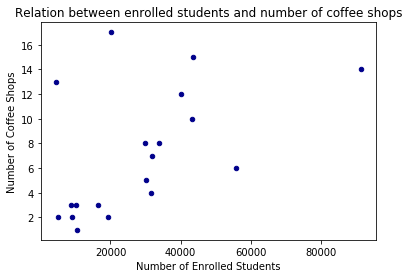

In [68]:
all_data.plot(kind='scatter', x='Total Students', y='NumberOfUniCafes',  c='DarkBlue')

plt.title('Relation between enrolled students and number of coffee shops')
plt.ylabel('Number of Coffee Shops')
plt.xlabel('Number of Enrolled Students')

plt.show() # need this line to show the updates made to the figure

While it is not the case for all the universities, it seems that the number of coffee shops around universities tends to increase with increased number of enrolled students.

Let's now check the distribution of the tuition fees and the distribution of the enrolled students.

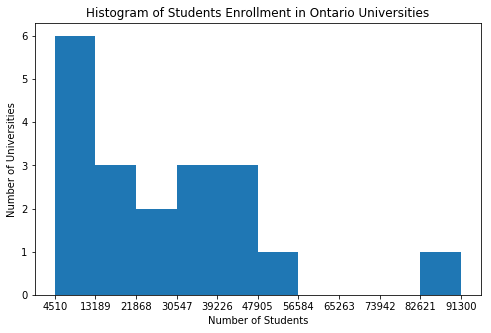

In [70]:
# I need to first define ranges, right?
count, bin_edges = np.histogram(all_data['Total Students']) # 5 is number of pins, can be removed for default is 10

all_data['Total Students'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Students Enrollment in Ontario Universities') # add a title to the histogram
plt.ylabel('Number of Universities') # add y-label
plt.xlabel('Number of Students') # add x-label

plt.show()

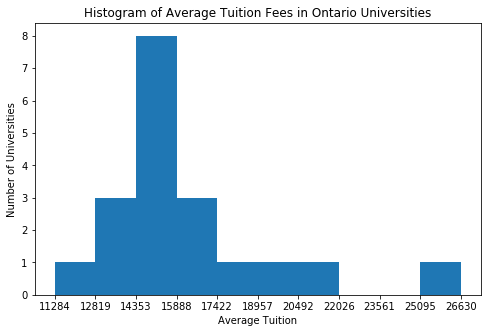

In [71]:
# I need to first define ranges, right?
count, bin_edges = np.histogram(all_data['Average Tuition']) # 5 is number of pins, can be removed for default is 10

all_data['Average Tuition'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Average Tuition Fees in Ontario Universities') # add a title to the histogram
plt.ylabel('Number of Universities') # add y-label
plt.xlabel('Average Tuition') # add x-label

plt.show()

Most of the universities tuitions fees goes around 15000, with one university being way more expensive than others. 

#### Clustering

Let's first select which features we will consider for clustering and then normalize our data:

In [72]:
#Pre_processing before clustering 

data_for_clustering = all_data[['Total Students', 'Average Tuition', 'NumberOfUniCafes', 'DistanceToUni']]

#'City Population'

#data_for_clustering = all_data.drop(['University','Main Campus City'],axis =1)

In [74]:
data_for_clustering = StandardScaler().fit_transform(data_for_clustering)

data_for_clustering

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.43265616, -0.03139554, -1.04006871, -0.44830166],
       [ 0.16236651, -0.07154489, -0.63261911, -0.2438985 ],
       [-0.93999127, -0.48915832, -0.83634391, -1.72265413],
       [-0.92071928, -0.31409814, -1.04006871, -1.23196412],
       [ 0.28088924, -0.16766226,  0.18228008,  0.88471472],
       [-1.10958478, -0.96771137, -1.04006871, -0.98330706],
       [-1.13801096, -0.48192692,  1.20090408,  1.07482176],
       [ 0.08431495,  1.47831016,  0.18228008,  0.97252401],
       [ 0.72414499, -0.14431086,  0.58972968,  1.32714244],
       [-0.85663992, -0.84522951, -1.24379351,  1.7835643 ],
       [ 0.09587815, -1.44679172, -0.42889431, -1.08149137],
       [-0.86772131, -0.86225344, -0.83634391, -0.3477107 ],
       [ 0.73570819,  0.90959057,  1.60835368,  0.49248013],
       [ 3.04352889,  3.17708689,  1.40462888,  0.46935179],
       [ 0.57189628,  0.67713115,  0.99717928,  0.0561497 ],
       [ 0.1801931 ,  0.26456463, -0.02144472,  0.85628196],
       [-0.56466928, -0.

Let's fit our model with number of clusters equal to 3, and then add the labels to our data frame:

In [78]:
numberOfClusters = 3
kmeanModel = KMeans(n_clusters=numberOfClusters).fit(data_for_clustering)

In [79]:
all_data['Labels'] = kmeanModel.labels_

In [80]:
all_data.sort_values(by='Labels', axis=0, ascending=True, inplace=True)
all_data.head(all_data.shape[0])

,University,Main Campus City,Total Students,Average Tuition,City Population,City_Latitude,City_Longitude,Uni_Latitude,Uni_Longitude,NumberOfUniCafes,NumberOfCityCafes,DistanceToUni,Labels
9,Trent University,Peterborough,10350,13280.50,75877,44.300000,-78.333333,44.3564,-78.2902,1,1.0,0.797926,0
15,University of Western Ontario,London,31870,16963.75,346765,42.983333,-81.250000,43.0096,-81.2737,7,20.0,0.656134,0
14,University of Waterloo,Waterloo,40000,18333.00,97475,43.464300,-80.520400,43.4723,-80.5449,12,26.0,0.533785,0
4,McMaster University,Hamilton,33960,15529.25,519949,43.256101,-79.857484,43.2609,-79.9192,8,14.0,0.660482,0
12,University of Ottawa,Ottawa,43400,19104.50,812129,45.416667,-75.700000,45.4231,-75.6831,15,51.0,0.600505,0
6,Ontario College of Art and Design University,Toronto,4510,14486.25,2600000,43.666667,-79.416667,43.6530,-79.3912,13,52.0,0.689551,0
7,Queen's University,Kingston,29880,20992.00,114195,44.300000,-76.566667,44.2253,-76.4951,8,0.0,0.673909,0
8,Ryerson University,Toronto,43160,15606.75,2600000,43.666667,-79.416667,43.6577,-79.3788,10,52.0,0.728134,0
17,Wilfrid Laurier University,Waterloo,20100,15075.50,97475,43.464300,-80.520400,43.4724,-80.5263,17,26.0,0.595299,0
16,University of Windsor,Windsor,16410,14762.00,278013,42.301649,-83.030744,42.3043,-83.0660,3,0.0,0.317714,1


Let's look at the mean of each cluster:

In [81]:
all_data.groupby('Labels').mean()

,Total Students,Average Tuition,City Population,City_Latitude,City_Longitude,Uni_Latitude,Uni_Longitude,NumberOfUniCafes,NumberOfCityCafes,DistanceToUni
Labels,,,,,,,,,,
0,28581.111111,16596.833333,8.070961e+05,43.835337,-79.064624,43.836744,-79.055833,10.111111,26.888889,0.659525
1,20660.000000,14402.972222,4.992490e+05,44.798798,-80.684353,44.809678,-80.706500,3.333333,13.777778,0.382898
2,91300.000000,26630.000000,2.600000e+06,43.666667,-79.416667,43.662900,-79.395700,14.000000,52.000000,0.596968


Let's visualize our clusters:

In [84]:
# create map

latitude = 51.2538
longitude = -85.3232


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(numberOfClusters)
ys = [i + x + (i*x)**2 for i in range(numberOfClusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_data['Uni_Latitude'], all_data['Uni_Longitude'], all_data['Main Campus City'], all_data['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Results <a name='results'> </a>

The analysis shows that cluster number 2 has only one university, that is University of Toronto. It was no surprise  that no other university fitted within its cluster, taking into consideration the very high number of students in it. Although it has a relatively high number of coffee shops near, we still recommend the investor to consider it for further analysis as the number of students is significantly high and the tuition fees are also high indicating a possibly good market. 

Cluster 1 mostly includes universities with low number of coffee shops around them reducing the risk of competition. While cluster 0 has mostly universities with higher number of coffee shops around them and on average higher number of enrolled students then cluster 1.

### Discussion <a name='discussion'> </a>

As a result of this analysis we can recommend to the investor to look further around University of Toronto. However, we believe more features could serve in better clustering for universities in clusters 0 and 1.

It would be beneficial to investigate the availability of cafeterias within campuses and how do students feed about them, and study locations on campuses.

Additionally, it is possible to survey the students of the selected universities to study their interest in opening a new coffee shop. It would also be a good opportunity to ask students about how much on average they spend on coffee per week, for example, or their willingness to study at a coffee shop.


### Conclusion and Future Directions <a name='conclusion'> </a>

Considering students constant need for coffee and their interest in studying at coffee shops, starting a Student Coffee Shop near a university campus has a high potential for success. The main question is where to open it? In this study I worked on narrowing down the search area for potential investor looking for a location in Ontario Canada to start such business.The analysis resulted in recommending University of Toronto  and probably deeper research for the potential market.

Investors are recommended to thoroughly study locations within the streets around the selected campus. The analysis should take into consideration the success rates of existing businesses around the area as successful businesses usually attract other successful businesses. 

### References

[1] <a name ='ref1'> </a>Mehta, Ravi, Rui Zhu, and Amar Cheema. "Is noise always bad? Exploring the effects of ambient noise on creative cognition." Journal of Consumer Research 39, no. 4 (2012): 784-799

[2] <a name ='ref2'> </a>Mahoney, Caroline R., Grace E. Giles, Bernadette P. Marriott, Daniel A. Judelson, Ellen L. Glickman, Paula J. Geiselman, and Harris R. Lieberman. "Intake of caffeine from all sources and reasons for use by college students." Clinical Nutrition 38, no. 2 (2019): 668-675.
